<a href="https://colab.research.google.com/github/FajriyaHasnaPutri/Algoritma-dan-Struktur-Data-II/blob/main/FastSpeech_TFLITE_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorflowTTS [FastSpeech2] TFLite

## Persiapan Dependecies dan environment

In [23]:
# Install tensorflow 2.7.0 agar sesuai dengan tensorflowtts dependencies
!pip install tensorflow==2.7.0
# !pip install tensorflow-gpu==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import tensorflow
# memastikan versi tensorflow
print(tensorflow.__version__)

2.7.0


In [25]:
# Install german_transliterate hanya untuk pelengkap soalnya kalau tidak ada, nanti error
!pip install git+https://github.com/repodiac/german_transliterate
# Install TensorflowTTS sebagai package / library / toolkit utama untuk pipeline speech synthesis
!pip install TensorFlowTTS
# warning dari PIP diabaikan karena selama program jalan, kenapa tidak?

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/repodiac/german_transliterate to /tmp/pip-req-build-hj0otans
  Running command git clone -q https://github.com/repodiac/german_transliterate /tmp/pip-req-build-hj0otans
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Segala Module dan Class yang dibutuhkan

In [26]:
# import semua package yang dibutuhkan
import numpy as np
import soundfile as sf
import yaml
import tensorflow as tf

# import Class-class yang dibutuhkan untuk preprocessing teks ke array inputan 
# di model, nah saat mau input kan ada teks diubah ke array angka berurutan 
# (sequence), acuannya ya lewat corpus yang sudah tersedia dari modul TensorflowTTS,
# lalu import modul untuk download pre-trained model, dan config FastSpeech2
from tensorflow_tts.inference import AutoProcessor
from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel

# import IPython display audio untuk memutar audio yang dihasilkan di google colab
from IPython.display import Audio

## Persiapkan Model 

In [27]:
# initialize melgan model (neural vocoder, yang mengubah mel-spectrogram menjadi suara)
melgan = TFAutoModel.from_pretrained("tensorspeech/tts-melgan-ljspeech-en")

In [28]:
# initialize FastSpeech model (download model untuk menghasilkan mel-spectrogram dan config-nya)
fastspeech = TFAutoModel.from_pretrained("tensorspeech/tts-fastspeech-ljspeech-en")

## Inference tanpa diubah ke TFLite

In [29]:
# Inference tanpa TFLite

# Masukkan teks bahasa inggris yang mau diubah menjadi suara pada variable ini
input_text = "Thanks for waiting me to marry."

# Intansiasi Class Autoprocessor untuk ubah teks ke array
processor = AutoProcessor.from_pretrained("tensorspeech/tts-fastspeech-ljspeech-en")
# ubah teks inputan ke array (sequence)
input_ids = processor.text_to_sequence(input_text.lower())

# inference model Fastspeech dengan input 
# *input_ids = sequence (teks), 
# *speaker_ids = id speaker dari dataset LJSpeech (LJSpeech adalah Dataset 
#                rekaman suara dari beberapa orang.)
# *speed_ratios = 1.0 adalah skala kecepatan normal berbicara
mel_before, mel_after, duration_outputs = fastspeech.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32)
)

audio_before = melgan(mel_before)[0, :, 0]
audio_after = melgan(mel_after)[0, :, 0]

In [30]:
Audio(data=audio_before, rate=22050)

In [31]:
Audio(data=audio_after, rate=22050)

### Lihat Mel-Spectrogram

In [32]:
import numpy as np
import matplotlib.pyplot as plt

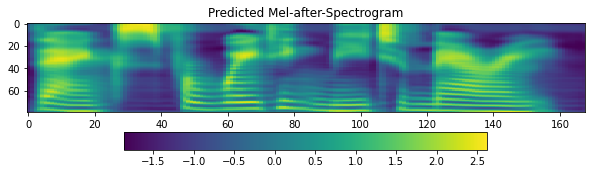

In [33]:
mel_before = tf.reshape(mel_before, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_before), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

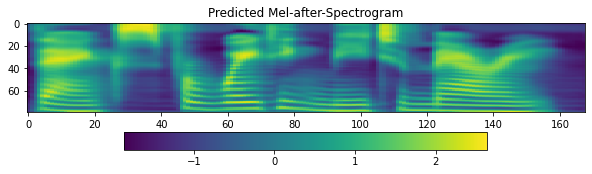

In [34]:
# mel Spectrogram after
mel_after = tf.reshape(mel_after, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_after), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

## Proses Ubah ke Tensorflow Lite

In [35]:
# Concrete Function (memasukkan concrete function "_inference" dari mode fastspeech ke variable di bawah)
fastspeech_concrete_function = fastspeech.inference_tflite.get_concrete_function()

In [36]:
# mempersiapkan converter dari model biasa ke versi tflite
converter = tf.lite.TFLiteConverter.from_concrete_functions(
    [fastspeech_concrete_function]
)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

In [37]:
# Save the TF Lite model.
with open('fastspeech_quant.tflite', 'wb') as f:
  f.write(tflite_model)

print('Model size is %f MBs.' % (len(tflite_model) / 1024 / 1024.0) )

Model size is 28.561081 MBs.


## Persiapan Inference dengan model TFLite

In [38]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
# interpreter ibarat sebuah mesin yang dijejalkan/dipasangi model (fastspeech)
# ditengahnya dan punya saluran input dan output yang harus disesuaikan dengan model-nya
interpreter = tf.lite.Interpreter(model_path='fastspeech_quant.tflite')

# Get input and output tensors. (berguna untuk mendapatkan detail pengaturan
#                                saluran input dan output interpreter yang
#                                nantinya akan digunakan untuk menyesuaikan
#                                teks inputan dan output mel-spectrogram )
input_details = interpreter.get_input_details()
print(input_details)
output_details = interpreter.get_output_details()

# Prepare input data.
def prepare_input(input_ids):
  """ Penyesuaian inputan teks ke interpreter.
  interpreter menerima bentuk tensor, bukan teks maupun sequence sehingga
  perlu perubahan ke bentuk tensor dan penyesuaian shape/dimension 
  dulu sebelum masuk ke interpreter
  """
  input_ids = tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0)
  return (input_ids,
          tf.convert_to_tensor([0], tf.int32),
          tf.convert_to_tensor([1.0], dtype=tf.float32),
          tf.convert_to_tensor([1.0], dtype=tf.float32),
          tf.convert_to_tensor([1.0], dtype=tf.float32))

# Test the model on random input data.
def infer(input_text):
  """ Fungsi model inference / menjalankan model
  dengan inputan *input_text[string] diubah menjadi array (sequence)
  lalu disesuaikan dengan dimensi array dari interpreter dan mendapatkan
  output melalui fungsi invoke dari interpreter.
  mengembalikan 2 tensor array yang keduanya adalah 
  """
  # instansiasi Class preprocess untuk fastspeech
  processor = AutoProcessor.from_pretrained("tensorspeech/tts-fastspeech-ljspeech-en")
  # mengubah teks menjadi array (sequence)
  input_ids = processor.text_to_sequence(input_text.lower())
  # mempersiapkan input tensor dari interpreter
  interpreter.resize_tensor_input(input_details[0]['index'], 
                                  [1, len(input_ids)])
  interpreter.resize_tensor_input(input_details[1]['index'], 
                                  [1])
  interpreter.resize_tensor_input(input_details[2]['index'], 
                                  [1])
  interpreter.allocate_tensors()
  # menyesuaikan inputan (sequence) ke bentuk yang dapat diterima oleh interpreter
  input_data = prepare_input(input_ids)
  for i, detail in enumerate(input_details):
    print(i, 'detail = ', detail)
    input_shape = detail['shape_signature']
    interpreter.set_tensor(detail['index'], input_data[i])

  # menjalankan interpreter / inference model / memproses mel-spectrogram
  interpreter.invoke()

  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  return (interpreter.get_tensor(output_details[0]['index']),
          interpreter.get_tensor(output_details[1]['index']))



[{'name': 'input_ids', 'index': 0, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([ 1, -1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'speaker_ids', 'index': 1, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'speed_ratios', 'index': 2, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [39]:
output_details

[{'dtype': numpy.float32,
  'index': 955,
  'name': 'Identity',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([ 1,  1, 80], dtype=int32),
  'shape_signature': array([-1, -1, 80], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.float32,
  'index': 991,
  'name': 'Identity_1',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([ 1,  1, 80], dtype=int32),
  'shape_signature': array([-1, -1, 80], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.int32,
  'index': 588,
  'name': 'Identity_2',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 1], dtype=int32),
  'shape_

## Inference dengan model versi TFLite

In [50]:
input_text = "i love you"

decoder_output_tflite, mel_output_tflite = infer(input_text)
audio_before_tflite = melgan(decoder_output_tflite)[0, :, 0]
audio_after_tflite = melgan(mel_output_tflite)[0, :, 0]

0 detail =  {'name': 'input_ids', 'index': 0, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([ 1, -1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
1 detail =  {'name': 'speaker_ids', 'index': 1, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
2 detail =  {'name': 'speed_ratios', 'index': 2, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension':

In [51]:
Audio(data=audio_before_tflite, rate=22050)

In [52]:
Audio(data=audio_after_tflite, rate=22050)

### Lihat Mel-Spectrogram

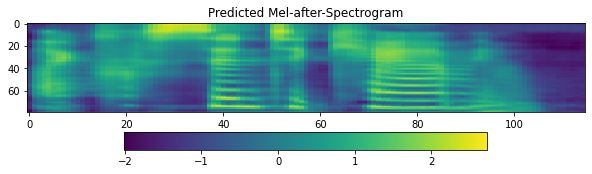

In [48]:
decoder_output_tflite = tf.reshape(decoder_output_tflite, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(decoder_output_tflite), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

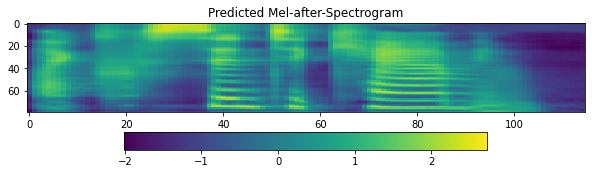

In [49]:
mel_output_tflite = tf.reshape(mel_output_tflite, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_output_tflite), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()